In [147]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import *
import scipy
from statsmodels.sandbox.stats.multicomp import multipletests 

%matplotlib inline

# Обнаружение статистически значимых отличий в уровнях экспрессии генов больных раком

Это задание поможет вам лучше разобраться в методах множественной проверки гипотез и позволит применить ваши знания на данных из реального биологического исследования.

В этом задании вы:
 
- вспомните, что такое t-критерий Стьюдента и для чего он применяется
- сможете применить технику множественной проверки гипотез и увидеть собственными глазами, как она работает на реальных данных
- почувствуете разницу в результатах применения различных методов поправки на множественную проверку

# Описание используемых данных

Данные для этой задачи взяты из исследования, проведенного в Stanford School of Medicine. В исследовании была предпринята попытка выявить набор генов, которые позволили бы более точно диагностировать возникновение рака груди на самых ранних стадиях.

В эксперименте принимали участие 24 человек, у которых не было рака груди (normal), 25 человек, у которых это заболевание было диагностировано на ранней стадии (early neoplasia), и 23 человека с сильно выраженными симптомами (cancer).

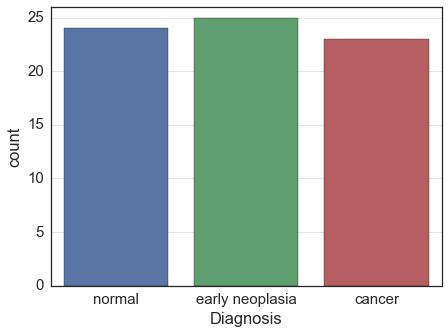

Ученые провели секвенирование биологического материала испытуемых, чтобы понять, какие из этих генов наиболее активны в клетках больных людей.

Секвенирование — это определение степени активности генов в анализируемом образце с помощью подсчёта количества соответствующей каждому гену РНК.

В данных для этого задания вы найдете именно эту количественную меру активности каждого из 15748 генов у каждого из 72 человек, принимавших участие в эксперименте.

Вам нужно будет определить те гены, активность которых у людей в разных стадиях заболевания отличается статистически значимо.

Кроме того, вам нужно будет оценить не только статистическую, но и практическую значимость этих результатов, которая часто используется в подобных исследованиях.

Диагноз человека содержится в столбце под названием "Diagnosis".

## Практическая значимость изменения

Цель исследований — найти гены, средняя экспрессия которых отличается не только статистически значимо, но и достаточно сильно. В экспрессионных исследованиях для этого часто используется метрика, которая называется fold change (кратность изменения). Определяется она следующим образом:


$F_c(C, T) = \begin{cases} \frac{T}{C}, & T \gt C \\ -\frac{C}{T}, & T \lt C \end{cases}$

где  $C, T$  — средние значения экспрессии гена в control и treatment группах соответственно. По сути, fold change показывает, во сколько раз отличаются средние двух выборок.

# Данные

## Посмотрим на данные

In [6]:
data = pd.read_csv('gene_high_throughput_sequencing.csv')
data

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,STT5750_Breast_021_DCIS,cancer,1.466240,3.689955,21.331981,19.359546,23.505609,11.576176,11.325851,80.572057,...,2.807635,1.466240,2.807635,1.466240,2.807635,3.689955,18.449777,1.466240,1.466240,1.466240
68,STT5751_Breast_021_IDC,cancer,2.492410,12.279444,30.087759,17.703926,26.064890,10.707081,11.520120,65.041865,...,2.492410,2.492410,1.301619,3.275668,1.301619,1.301619,8.601194,1.301619,1.301619,1.301619
69,STT5758_Breast_022_IDC,cancer,3.530477,20.006038,53.924651,25.449565,30.949995,16.794696,17.121366,70.958462,...,1.176826,1.176826,1.176826,2.961613,1.176826,1.176826,10.764365,1.176826,1.176826,1.176826
70,STT5763_Breast_022_IDC,cancer,3.733734,8.860505,32.538666,21.585069,24.987992,11.460224,11.201202,67.767125,...,2.840946,1.483635,1.483635,1.483635,1.483635,1.483635,8.522837,1.483635,1.483635,1.483635


In [9]:
%%time
data.describe()

Wall time: 23.3 s


,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,ISG15,AGRN,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,...,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,2.463922,7.100958,19.056151,15.618688,23.537120,11.303466,8.921396,63.270147,53.906324,70.678573,...,5.563444,2.192029,1.967424,2.181360,1.729308,1.980733,16.834075,1.825827,2.287380,1.756827
std,1.413687,4.164703,9.287753,4.664146,4.475294,4.055122,3.270713,13.792140,45.635498,21.326237,...,2.389789,2.454218,2.047129,2.542652,1.507149,2.230157,7.126802,1.902716,3.185571,1.623151
min,0.833898,1.231043,4.941211,6.395270,8.520713,2.066576,1.364917,42.544976,24.616767,42.631422,...,1.144240,0.853957,0.853957,0.853957,0.833898,0.833898,4.675683,0.833898,0.853957,0.833898
25%,1.284642,3.892403,13.423946,12.574596,21.151624,8.712898,6.213396,53.093627,34.009687,54.202100,...,3.805875,1.042783,1.011350,1.011350,1.003337,1.003337,11.186633,1.003337,1.011350,1.003337
50%,2.104677,6.315551,16.734855,14.586150,23.477006,11.172590,8.703397,63.230911,39.554954,65.510651,...,5.617824,1.339507,1.273861,1.298543,1.252527,1.252527,16.514389,1.252527,1.273861,1.252527
75%,3.345067,8.916399,21.884325,17.695678,26.471909,13.568625,11.139240,69.880705,50.295756,79.427207,...,7.100942,1.815754,1.647255,1.677971,1.625364,1.611299,21.849385,1.607345,1.647255,1.611299
max,7.364879,20.006038,60.584449,29.659104,34.110743,27.441093,17.121366,132.144503,327.590426,128.606260,...,11.227770,11.913855,10.883310,11.692697,10.392539,10.640754,49.295538,9.919132,17.278985,9.333904


In [8]:
data.Diagnosis.value_counts()

early neoplasia    25
normal             24
cancer             23
Name: Diagnosis, dtype: int64

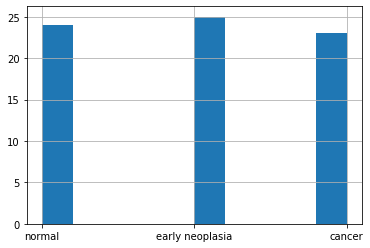

In [19]:
data.Diagnosis.hist()

Подготовим данные

In [53]:
normal = data[data.Diagnosis == 'normal']
early_neoplasia = data[data.Diagnosis == 'early neoplasia']
cancer = data[data.Diagnosis == 'cancer']

In [54]:
normal.drop(['Patient_id', 'Diagnosis'], axis=1, inplace=True)
early_neoplasia.drop(['Patient_id', 'Diagnosis'], axis=1, inplace=True)
cancer.drop(['Patient_id', 'Diagnosis'], axis=1, inplace=True)

C:\Users\Vlad\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [59]:
early_neoplasia.reset_index(drop=True, inplace=True)
cancer.reset_index(drop=True, inplace=True)

# Часть 1: применение t-критерия Стьюдента

В первой части вам нужно будет применить критерий Стьюдента для проверки гипотезы о равенстве средних в двух независимых выборках. Применить критерий для каждого гена нужно будет дважды:

- для групп normal (control) и early neoplasia (treatment)
- для групп early neoplasia (control) и cancer (treatment)

В качестве ответа в этой части задания необходимо указать количество статистически значимых отличий, которые вы нашли с помощью t-критерия Стьюдента, то есть число генов, у которых p-value этого теста оказался меньше, чем уровень значимости.

In [25]:
print(normal.LOC643837.mean())
print(early_neoplasia.LOC643837.mean())
print(cancer.LOC643837.mean())

2.681277296041667
2.5108939967199997
2.1860597410869564


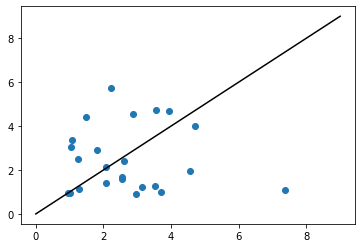

In [43]:
plt.scatter(normal.LOC643837, early_neoplasia.LOC643837[:24])
plt.plot(range(10), c = 'black')
plt.show()

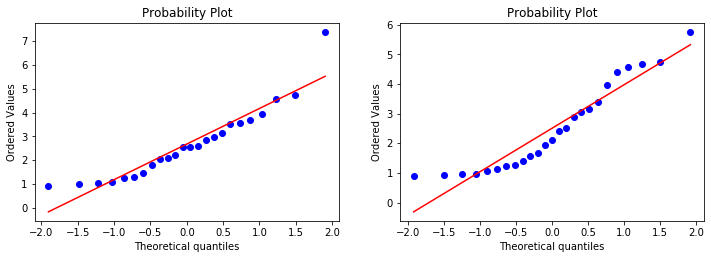

In [44]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
stats.probplot(normal.LOC643837, dist="norm", plot=plt)
plt.subplot(2,2,2)
stats.probplot(early_neoplasia.LOC643837, dist="norm", plot=plt)
plt.show()

Критерий Шапиро-Уилка:

 $H_0\colon$ нормально
 
 $H_1\colon$ не нормально

In [45]:
print("Shapiro-Wilk normality test (normal), W-statistic: %f, p-value: %f" % stats.shapiro(normal.LOC643837))
print("Shapiro-Wilk normality test (cancer), W-statistic: %f, p-value: %f" % stats.shapiro(cancer.LOC643837))
print("Shapiro-Wilk normality test (early_neoplasia), W-statistic: %f, p-value: %f" % stats.shapiro(early_neoplasia.LOC643837))

Shapiro-Wilk normality test (normal), W-statistic: 0.895629, p-value: 0.017408
Shapiro-Wilk normality test (cancer), W-statistic: 0.853136, p-value: 0.003103
Shapiro-Wilk normality test (early_neoplasia), W-statistic: 0.897122, p-value: 0.015890


Критерий Стьюдента:

$H_0\colon$ средние значения эксперсии гена LOC643837 одинаковы для здоровых пациентов, и для пациентов с раком.

$H_1\colon$ не одинаковы.

In [46]:
print(normal.LOC643837.std())
print(early_neoplasia.LOC643837.std())

1.5084859354232254
1.4693977653278496


In [47]:
scipy.stats.ttest_ind(normal.LOC643837, early_neoplasia.LOC643837, equal_var = False)

Ttest_indResult(statistic=0.40028855552482717, pvalue=0.6907660157497355)

In [111]:
norm_en_t = []

for column in normal.columns:
    ttest_indResult = scipy.stats.ttest_ind(normal[column], early_neoplasia[column], equal_var = False)
    norm_en_t.append([column, ttest_indResult.pvalue])

In [152]:
norm_en_t = pd.DataFrame(norm_en_t)
norm_en_t.columns = ['gene', 'p-value']

In [154]:
norm_en_t

,gene,p-value
0,LOC643837,0.690766
1,LOC100130417,0.000032
2,SAMD11,0.060273
3,NOC2L,0.826429
4,KLHL17,0.049876
...,...,...
15743,DDX3Y,0.640904
15744,CD24,0.830134
15745,CYorf15B,0.670395
15746,KDM5D,0.793925


In [187]:
en_cancer_t = []

for column in normal.columns:
    ttest_indResult = scipy.stats.ttest_ind(early_neoplasia[column], cancer[column], equal_var = False)
    en_cancer_t.append([column, ttest_indResult.pvalue])

In [188]:
en_cancer_t = pd.DataFrame(en_cancer_t)
en_cancer_t.columns = ['gene', 'p-value']

In [189]:
en_cancer_t

,gene,p-value
0,LOC643837,0.413735
1,LOC100130417,0.653429
2,SAMD11,0.079556
3,NOC2L,0.287581
4,KLHL17,0.463292
...,...,...
15743,DDX3Y,0.659369
15744,CD24,0.330617
15745,CYorf15B,0.542939
15746,KDM5D,0.565753


In [192]:
norm_en_t[norm_en_t['p-value'] < 0.05]

,gene,p-value
1,LOC100130417,0.000032
4,KLHL17,0.049876
7,HES4,0.023712
9,AGRN,0.037933
10,C1orf159,0.020002
...,...,...
15687,ZNF185,0.043227
15700,SRPK3,0.036647
15726,SLC10A3,0.007540
15728,G6PD,0.032166


In [160]:
en_cancer_t[en_cancer_t['p-value'] < 0.05]

,gene,p-value
5,0.007681,0.007681
8,0.000740,0.000740
12,0.006844,0.006844
13,0.002094,0.002094
16,0.031126,0.031126
...,...,...
15722,0.039011,0.039011
15723,0.005073,0.005073
15724,0.004185,0.004185
15726,0.030746,0.030746


# Часть 2: поправка методом Холма

В этой части задания нужно будет применить поправку Холма для получившихся двух наборов достигаемых уровней значимости из предыдущей части. Обратите внимание, что поскольку вы будете делать поправку для каждого из двух наборов p-value отдельно, то проблема, связанная с множественной проверкой останется.

Для того, чтобы ее устранить, достаточно воспользоваться поправкой Бонферрони, то есть использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Холма-Бонферрони. Причем это число нужно ввести с учетом практической значимости: посчитайте для каждого значимого изменения fold change и выпишите в ответ число таких значимых изменений, абсолютное значение fold change которых больше, чем 1.5.

Обратите внимание, что

- применять поправку на множественную проверку нужно ко всем значениям достигаемых уровней значимости, а не только для тех, которые меньше значения уровня доверия.
- при использовании поправки на уровне значимости 0.025 меняются значения достигаемого уровня значимости, но не меняется значение уровня доверия (то есть для отбора значимых изменений скорректированные значения уровня значимости нужно сравнивать с порогом 0.025, а не 0.05)!

In [193]:
reject, p_corrected, a1, a2 = multipletests(norm_en_t['p-value'], 
                                            alpha = 0.05 / 2, 
                                            method = 'holm') 

In [194]:
norm_en_t['p_corrected'] = p_corrected

In [195]:
norm_en_t

,gene,p-value,p_corrected
0,LOC643837,0.690766,1.000000
1,LOC100130417,0.000032,0.500174
2,SAMD11,0.060273,1.000000
3,NOC2L,0.826429,1.000000
4,KLHL17,0.049876,1.000000
...,...,...,...
15743,DDX3Y,0.640904,1.000000
15744,CD24,0.830134,1.000000
15745,CYorf15B,0.670395,1.000000
15746,KDM5D,0.793925,1.000000


In [196]:
norm_en_t[norm_en_t['p_corrected'] < 0.025]

,gene,p-value,p_corrected
7244,PCSK4,7.955435e-07,0.012527
9820,EEF1A2,8.498742e-08,0.001338


In [197]:
def fold_change(T, C):
    if T > C:
        return T / C
    elif T < C:
        return -C / T

In [198]:
normal[['PCSK4', 'EEF1A2']].mean()

PCSK4     14.983424
EEF1A2    19.373612
dtype: float64

In [199]:
early_neoplasia[['PCSK4', 'EEF1A2']].mean()

PCSK4     22.621756
EEF1A2    38.260320
dtype: float64

In [200]:
fold_change(early_neoplasia[['PCSK4']].mean().values, normal[['PCSK4']].mean().values)

array([1.50978548])

In [201]:
fold_change(early_neoplasia[['EEF1A2']].mean().values, normal[['EEF1A2']].mean().values)

array([1.97486767])

2 отличия значимы статистически и практически: PCSK4, EEF1A2

In [202]:
reject, p_corrected, a1, a2 = multipletests(en_cancer_t['p-value'], 
                                            alpha = 0.05 / 2, 
                                            method = 'holm') 

In [203]:
en_cancer_t['p_corrected'] = p_corrected

In [204]:
en_cancer_t

,gene,p-value,p_corrected
0,LOC643837,0.413735,1.0
1,LOC100130417,0.653429,1.0
2,SAMD11,0.079556,1.0
3,NOC2L,0.287581,1.0
4,KLHL17,0.463292,1.0
...,...,...,...
15743,DDX3Y,0.659369,1.0
15744,CD24,0.330617,1.0
15745,CYorf15B,0.542939,1.0
15746,KDM5D,0.565753,1.0


In [217]:
en_cancer_t_p = en_cancer_t[en_cancer_t['p_corrected'] < 0.025]

In [222]:
en_cancer_t_p

,gene,p-value,p_corrected
47,GABRD,2.276043e-07,0.003575
283,EXTL1,1.087046e-07,0.001709
316,CD164L2,1.002085e-06,0.015708
1105,NES,1.041679e-07,0.001637
1238,FMO2,1.103311e-06,0.017292
...,...,...,...
15090,LAMC3,1.938708e-09,0.000031
15449,SLC7A3,3.981097e-08,0.000626
15576,CAPN6,7.554205e-08,0.001188
15640,GPC3,5.832350e-07,0.009152


In [224]:
en_cancer_fc = []
for column in en_cancer_t_p.gene:
    fc = fold_change(cancer[column].mean(), early_neoplasia[column].mean())
    en_cancer_fc.append([column, fc])

In [225]:
en_cancer_fc = pd.DataFrame(en_cancer_fc, columns=['gene', 'fold_change'])

In [226]:
en_cancer_fc

,gene,fold_change
0,GABRD,1.843860
1,EXTL1,-2.383210
2,CD164L2,-1.997381
3,NES,-1.693428
4,FMO2,-1.795640
...,...,...
74,LAMC3,-2.868940
75,SLC7A3,-3.224495
76,CAPN6,-2.559150
77,GPC3,-1.870434


In [227]:
en_cancer_fc[abs(en_cancer_fc.fold_change) > 1.5]

,gene,fold_change
0,GABRD,1.843860
1,EXTL1,-2.383210
2,CD164L2,-1.997381
3,NES,-1.693428
4,FMO2,-1.795640
...,...,...
74,LAMC3,-2.868940
75,SLC7A3,-3.224495
76,CAPN6,-2.559150
77,GPC3,-1.870434


# Часть 3: поправка методом Бенджамини-Хохберга

Данная часть задания аналогична второй части за исключением того, что нужно будет использовать метод Бенджамини-Хохберга.

Обратите внимание, что методы коррекции, которые контролируют FDR, допускает больше ошибок первого рода и имеют большую мощность, чем методы, контролирующие FWER. Большая мощность означает, что эти методы будут совершать меньше ошибок второго рода (то есть будут лучше улавливать отклонения от H_0, когда они есть, и будут чаще отклонять H_0, когда отличий нет).

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Бенджамини-Хохберга, причем так же, как и во второй части, считать только такие отличия, у которых abs(fold change) > 1.5.

In [228]:
reject, p_corrected, a1, a2 = multipletests(norm_en_t['p-value'], 
                                            alpha = 0.05 / 2, 
                                            method = 'fdr_bh')

In [229]:
norm_en_t['p_corrected'] = p_corrected

In [230]:
norm_en_t

,gene,p-value,p_corrected
0,LOC643837,0.690766,0.966511
1,LOC100130417,0.000032,0.035698
2,SAMD11,0.060273,0.536103
3,NOC2L,0.826429,0.980777
4,KLHL17,0.049876,0.499016
...,...,...,...
15743,DDX3Y,0.640904,0.959885
15744,CD24,0.830134,0.980777
15745,CYorf15B,0.670395,0.963120
15746,KDM5D,0.793925,0.977360


In [232]:
norm_en_t_p = norm_en_t[norm_en_t['p_corrected'] < 0.025]
norm_en_t_p

,gene,p-value,p_corrected
4627,TMEM63C,2.222228e-06,0.008749
7244,PCSK4,7.955435e-07,0.006264
8250,CACNG8,2.015472e-06,0.008749
9820,EEF1A2,8.498742e-08,0.001338


In [234]:
norm_en_fc = []
for column in norm_en_t_p.gene:
    fc = fold_change(early_neoplasia[column].mean(), normal[column].mean())
    norm_en_fc.append([column, fc])

In [236]:
norm_en_fc = pd.DataFrame(norm_en_fc, columns=['gene', 'fold_change'])

In [237]:
norm_en_fc

,gene,fold_change
0,TMEM63C,1.663826
1,PCSK4,1.509785
2,CACNG8,1.754951
3,EEF1A2,1.974868


In [239]:
norm_en_fc[abs(norm_en_fc.fold_change) > 1.5]

,gene,fold_change
0,TMEM63C,1.663826
1,PCSK4,1.509785
2,CACNG8,1.754951
3,EEF1A2,1.974868


In [247]:
reject, p_corrected, a1, a2 = multipletests(en_cancer_t['p-value'], 
                                            alpha = 0.05 / 2, 
                                            method = 'fdr_bh') 

In [248]:
en_cancer_t['p_corrected'] = p_corrected

In [249]:
en_cancer_t

,gene,p-value,p_corrected
0,LOC643837,0.413735,0.675195
1,LOC100130417,0.653429,0.836406
2,SAMD11,0.079556,0.288873
3,NOC2L,0.287581,0.563007
4,KLHL17,0.463292,0.712214
...,...,...,...
15743,DDX3Y,0.659369,0.839293
15744,CD24,0.330617,0.603308
15745,CYorf15B,0.542939,0.766593
15746,KDM5D,0.565753,0.781327


In [250]:
en_cancer_t_p = en_cancer_t[en_cancer_t['p_corrected'] < 0.025]
en_cancer_t_p

,gene,p-value,p_corrected
8,ISG15,7.402400e-04,0.017556
17,FAM132A,2.945987e-04,0.009487
44,GNB1,1.154858e-03,0.022992
47,GABRD,2.276043e-07,0.000086
54,PLCH2,5.973956e-04,0.015198
...,...,...,...
15654,NCRNA00086,4.875591e-04,0.013193
15692,BGN,1.779494e-04,0.007186
15694,DUSP9,2.069987e-04,0.007799
15703,PDZD4,6.795085e-08,0.000045


In [251]:
en_cancer_fc = []
for column in en_cancer_t_p.gene:
    fc = fold_change(cancer[column].mean(), early_neoplasia[column].mean())
    en_cancer_fc.append([column, fc])

In [252]:
en_cancer_fc = pd.DataFrame(en_cancer_fc, columns=['gene', 'fold_change'])
en_cancer_fc

,gene,fold_change
0,ISG15,2.458867
1,FAM132A,-1.329884
2,GNB1,1.168026
3,GABRD,1.843860
4,PLCH2,-1.406503
...,...,...
827,NCRNA00086,-1.615783
828,BGN,1.763462
829,DUSP9,-2.173490
830,PDZD4,-1.758546


In [253]:
en_cancer_fc[abs(en_cancer_fc.fold_change) > 1.5]

,gene,fold_change
0,ISG15,2.458867
3,GABRD,1.843860
6,AJAP1,-1.567814
7,CA6,-1.736762
9,MASP2,-1.750200
...,...,...
826,GPC3,-1.870434
827,NCRNA00086,-1.615783
828,BGN,1.763462
829,DUSP9,-2.173490
